# **Credit Risk Analysis**

### dataset: https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset?resource=download

#**Import libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

In [ ]:
#set display max column to see all column
pd.set_option("display.max_columns", None)
pd.get_option("display.max_columns")

#set display max column to see all column
pd.set_option("display.max_rows", 150)
pd.get_option("display.max_rows")

150

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load dataset**

In [ ]:
path = "/content/drive/MyDrive/loan.csv"
data = pd.read_csv(path, engine='python')
#alternative
#data = pd.read_csv(path)
#data.sample(10000) -> can be time consuming

In [ ]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Preparation of data for analysis**

###1. Default flag investigation and synthesis

In [ ]:
data['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Transforming 'loan_status' to 'default_flag' - dependent variable.
A client who's status is default, charged off or late (be it 16 or 120 days) is cosindered a bad client. We're interested not only in clients defaulting but also those that are going to be late, since it's a sign a clieng may default, which means they are also worse than clients paying on time

In [ ]:
data['default_flag']= data.apply(lambda row: int(row['loan_status'] in ['Charged Off','Late (31-120 days)', 'Late (16-30 days)', 'Default', 'Does not meet the credit policy. Status:Charged Off ']), axis=1)

In [ ]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_flag
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


investigate data types

###2. Initial variables investigation

In [ ]:
print(data.dtypes)

id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

Investigate Grade

In [ ]:
data['grade'].value_counts()

B    3113
A    2765
C    1825
D    1220
E     718
F     292
G      67
Name: grade, dtype: int64

In [ ]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_flag
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,3213.000000,460.000000,10000.000000,10000.000000,10000.000000,9997.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,0.0,10000.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.000000
mean,9.635445e+05,1.185210e+06,12861.637500,12687.660000,12604.045587,12.428547,363.81508,7.026650e+04,13.990554,0.133500,0.849600,37.519763,94.297826,9.472200,0.046800,14008.839200,52.684455,22.540600,392.935115,391.407178,13831.287565,13726.387386,10862.491155,2837.790120,1.036130,129.970174,11.280360,3305.547886,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154900
std,7.933409e+04,8.805752e+04,8491.813747,8271.774837,8205.771867,4.239117,226.20985,4.832114e+04,6.612879,0.459673,1.040427,21.477246,20.355030,4.264885,0.214975,15205.930733,27.544090,11.098264,1348.448687,1344.131919,10177.614310,10074.725956,7855.519127,3260.981728,6.211648,833.797048,101.370626,5302.132587,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361827
min,4.581650e+05,3.940260e+05,1000.000000,1000.000000,750.000000,5.420000,22.24000,6.000000e+03,0.000000,0.000000,0.000000,1.000000,11.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,8.781782e+05,1.092339e+06,6000.000000,6000.000000,6000.000000,8.900000,193.58000,4.200000e+04,8.940000,0.000000,0.000000,20.000000,88.000000,6.000000,0.000000,4767.750000,31.200000,14.000000,0.000000,0.000000,6122.035000,6082.380000,5000.000000,739.217500,0.000000,0.000000,0.000000,276.060000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,9.879250e+05,1.211594e+06,11200.000000,11075.000000,11000.000000,12.420000,322.25000,6.000000e+04,14.020000,0.000000,1.000000,35.000000,98.000000,9.000000,0.000000,10160.500000,55.000000,21.000000,0.000000,0.000000,11337.250000,11263.575000,9499.995000,1594.050000,0.000000,0.000000,0.000000,639.645000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,1.033696e+06,1.263089e+06,17500.000000,17000.000000,16950.000000,15.270000,480.33000,8.450000e+04,19.150000,0.000000,1.000000,53.000000,109.000000,12.000000,0.000000,17815.250000,75.200000,29.000000,0.000000,0.000000,18625.890397,18452.647500,15000.000000,3655.675000,0.000000,0.000000,0.000000,4241.470000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,24.110000,1288.10000,1.782000e+06,29.920000,6.000000,8.000000,115.000000,119.000000,34.000000,2.000000,148804.000000,99.900000,79.000000,10418.060000,10410.560000,56809.051629,56475.050000,35000.010000,22930.840000,146.040000,29623.350000,3926.150000,36115.200000,0.0,NaN,1.0,Na

###3. Initial column elimination

Drop columns that have less than circa 30% of non missing values, in that case 250k

In [ ]:
data.dropna('columns',thresh=250000, inplace=True)

<ipython-input-7-47abe674bde8>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  data.dropna('columns',thresh=250000, inplace=True)


In [ ]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_flag
0,1077501,1296599,5000.0,5000.0,4975.0,36,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
1,1077430,1314167,2500.0,2500.0,2500.0,60,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
2,1077175,1313524,2400.0,2400.0,2400.0,36,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
3,1076863,1277178,10000.0,10000.0,10000.0,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
4,1075358,1311748,3000.0,3000.0,3000.0,60,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          887379 non-null  int64  
 1   member_id                   887379 non-null  int64  
 2   loan_amnt                   887379 non-null  float64
 3   funded_amnt                 887379 non-null  float64
 4   funded_amnt_inv             887379 non-null  float64
 5   term                        887379 non-null  int64  
 6   int_rate                    887379 non-null  float64
 7   installment                 887379 non-null  float64
 8   grade                       887379 non-null  object 
 9   sub_grade                   887379 non-null  object 
 10  emp_title                   835917 non-null  object 
 11  emp_length                  842554 non-null  object 
 12  home_ownership              887379 non-null  object 
 13  annual_inc    

Let's check some columns that we suspect might have really concentraded values. We can then delete them to save space and computation time

In [ ]:
data['pymnt_plan'].value_counts()

n    887369
y        10
Name: pymnt_plan, dtype: int64

In [ ]:
data['application_type'].value_counts()

INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64

In [ ]:
data['acc_now_delinq'].value_counts()

0.0     883236
1.0       3866
2.0        208
3.0         28
4.0          7
5.0          3
6.0          1
14.0         1
Name: acc_now_delinq, dtype: int64

In [ ]:
data['policy_code'].value_counts()

1.0    887379
Name: policy_code, dtype: int64

In [ ]:
data['collections_12_mths_ex_med'].value_counts()

0.0     875553
1.0      10824
2.0        732
3.0         88
4.0         23
5.0          7
6.0          2
16.0         1
20.0         1
7.0          1
10.0         1
14.0         1
Name: collections_12_mths_ex_med, dtype: int64

In [ ]:
data['pymnt_plan'].value_counts()

n    887369
y        10
Name: pymnt_plan, dtype: int64

In [ ]:
data['mths_since_last_delinq'].value_counts()

9.0      8591
6.0      8470
12.0     8368
8.0      8335
13.0     8318
         ... 
180.0       1
136.0       1
124.0       1
143.0       1
137.0       1
Name: mths_since_last_delinq, Length: 155, dtype: int64

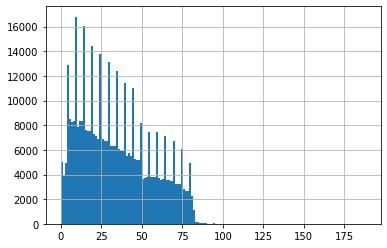

In [ ]:
data['mths_since_last_delinq'].hist(bins=150)

In [ ]:
data['initial_list_status'].value_counts()

f    456848
w    430531
Name: initial_list_status, dtype: int64

In [ ]:
del data['application_type']
del data['acc_now_delinq']
del data['policy_code']
del data['collections_12_mths_ex_med']
del data['url']
del data['pymnt_plan']
del data['next_pymnt_d']



Investigatee fields such as title and employer title, these variables don't make much sense since each value is taken by 1-2 observations, thus we delete them

In [ ]:
data['emp_title'].value_counts()

Teacher                                     13469
Manager                                     11240
Registered Nurse                             5525
Owner                                        5376
RN                                           5355
                                            ...  
Thomas J. Paul, Inc.                            1
Piggie Toes Preschool                           1
greystone park psychiatric hospital             1
Las Vegas Motropolitan Police Department        1
Manager Hotel Operations Oasis                  1
Name: emp_title, Length: 299271, dtype: int64

Looks like a good variable but we have to merge smaller counts into one so that the number of groups is not that large

In [ ]:
s=data['emp_title'].value_counts
s.groupby(np.where(s>=3000,s.index,'other')).sum()#.plot.pie()

Doesn't look that good anymore, too fragmented

In [ ]:
del data['emp_title']


In [ ]:
data['title'].value_counts()

Debt consolidation                     414001
Credit card refinancing                164331
Home improvement                        40112
Other                                   31892
Debt Consolidation                      15760
                                        ...  
New Heater                                  1
Looking to get out of debt                  1
Debt Conso/Pay off initial LC loan          1
Emergency Home Repair                       1
Credit Card/Auto Repair                     1
Name: title, Length: 63144, dtype: int64

In [ ]:
data['zip_code'].value_counts()

945xx    9770
750xx    9417
112xx    9272
606xx    8641
300xx    8126
         ... 
569xx       1
348xx       1
819xx       1
375xx       1
507xx       1
Name: zip_code, Length: 935, dtype: int64

Title and zip code don't make much sense as variables

In [ ]:
del data['zip_code']
del data['title']

loan_amnt, funded_amnt and funded_amnt_inv seem very similar in terms of values, most likely two of them will be thrown out at later stages

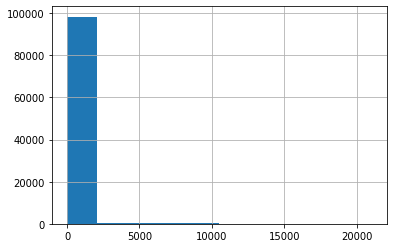

In [ ]:
(data['loan_amnt']-data['funded_amnt']).hist()

###4. Date Variables

Now proceed to date variables, we transform it so instead of a date they become number of days from that time until now.

In [ ]:
data['earliest_cr_line'].value_counts()

Nov-1998    103
Oct-2000    102
Jan-2000     91
Apr-2000     89
Nov-1999     88
           ... 
Mar-1963      1
Jun-1972      1
Dec-1969      1
Jan-1976      1
Aug-1972      1
Name: earliest_cr_line, Length: 465, dtype: int64

In [ ]:
data['last_credit_pull_d'].value_counts()

Jan-2016    3945
Dec-2014     440
Oct-2014     342
Sep-2014     322
Nov-2014     316
Dec-2015     237
Aug-2014     196
Nov-2015     172
Jan-2015     172
Jul-2015     169
Sep-2015     164
Oct-2015     160
Feb-2014     149
Feb-2013     142
Mar-2014     141
Apr-2015     135
Mar-2015     126
May-2015     126
Apr-2014     125
Nov-2013     118
Jan-2014     115
Jun-2014     113
Mar-2013     111
May-2014     109
Aug-2015     105
Oct-2013     102
Sep-2013     102
Dec-2013      99
Jul-2014      97
Jun-2015      97
Jul-2013      96
Feb-2015      95
May-2013      91
Apr-2013      86
Sep-2012      83
Nov-2012      81
Jun-2013      80
Dec-2012      80
Aug-2012      77
Aug-2013      74
Jun-2012      55
Jul-2012      55
Oct-2012      52
Mar-2012      47
Feb-2012      44
Apr-2012      41
May-2012      39
Jan-2012      23
Dec-2011      18
Oct-2011      12
Nov-2011      11
Sep-2011       5
Jan-2013       4
Aug-2011       4
Name: last_credit_pull_d, dtype: int64

In [ ]:
data['issue_d'].value_counts()

Dec-2011    2267
Nov-2011    2232
Oct-2011    2118
Sep-2011    2067
Aug-2011    1316
Name: issue_d, dtype: int64

In [ ]:
data['cr_history_length']=(pd.to_datetime('Jan-2023') - pd.to_datetime(data['earliest_cr_line'])).dt.days
data['since_last_cr_pull']=(pd.to_datetime('Jan-2023') - pd.to_datetime(data['last_credit_pull_d'])).dt.days
data['since_issue']=(pd.to_datetime('Jan-2023') - pd.to_datetime(data['issue_d'])).dt.days
data['since_last_pnmt']=(pd.to_datetime('Jan-2023') - pd.to_datetime(data['last_pymnt_d'])).dt.days

We can now drop original date variables

In [ ]:
del data['earliest_cr_line']
del data['last_credit_pull_d']
del data['issue_d']
del data['last_pymnt_d']

In [ ]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_flag,cr_history_length,since_last_cr_pull,since_issue,since_last_pnmt
0,1077501,1296599,5000.0,5000.0,4975.0,36,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,27.65,0.0,1.0,NaN,3.0,0.0,13648.0,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,NaN,NaN,NaN,NaN,0,13879.0,2557.0,4049,2922.0
1,1077430,1314167,2500.0,2500.0,2500.0,60,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,1.00,0.0,5.0,NaN,3.0,0.0,1687.0,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,NaN,NaN,NaN,NaN,1,8676.0,3409.0,4049,3562.0
2,1077175,1313524,2400.0,2400.0,2400.0,36,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,8.72,0.0,2.0,NaN,2.0,0.0,2956.0,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,NaN,NaN,NaN,NaN,0,7731.0,2557.0,4049,3136.0
3,1076863,1277178,10000.0,10000.0,10000.0,36,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,20.00,0.0,1.0,35.0,10.0,0.0,5598.0,21.0,37.0,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,NaN,NaN,NaN,NaN,0,9831.0,2922.0,4049,2922.0
4,1075358,1311748,3000.0,3000.0,3000.0,60,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Current,other,OR,17.94,0.0,0.0,38.0,15.0,0.0,27783.0,53.9,38.0,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,NaN,NaN,NaN,NaN,0,9862.0,2557.0,4049,2557.0


###5. Transform some object columns into numbers

Term variable consists only of '36 months' or '60 months', which we can simply transform into numbers

In [ ]:
data['term']=pd.to_numeric(data['term'].str[:3])

Transform employment length to number

In [ ]:
data['emp_length'].value_counts()

10+ years    291569
2 years       78870
< 1 year      70605
3 years       70026
1 year        57095
5 years       55704
4 years       52529
7 years       44594
8 years       43955
6 years       42950
9 years       34657
Name: emp_length, dtype: int64

In [ ]:
data['emp_length_num']=data['emp_length'].map({'< 1 year':0,'1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years': 7, '8 years': 8, '9 years':9, '10+ years':10})

In [ ]:
del data['emp_length']

###6. Drop the original target column and take one more look at the data

We can also drop loan_status, as we have transformed it into a default flag before

In [ ]:
del data['loan_status']

In [ ]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_flag,cr_history_length,since_last_cr_pull,since_issue,since_last_pnmt,emp_length_num
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,433067.000000,887350.000000,887350.000000,8.873790e+05,886877.000000,887350.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.171030e+05,8.171030e+05,8.171030e+05,887379.000000,887350.00000,887326.000000,887379.000000,869720.000000,842554.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,43.201090,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,34.063798,11.548469,0.195307,1.692079e+04,55.067693,25.268026,8403.124852,8399.713242,7558.826684,7521.160306,5757.706424,1754.804327,0.396692,45.919243,4.880757,2164.145585,2.257026e+02,1.394582e+05,3.206862e+04,0.068083,9066.13260,2623.986856,3096.714597,2699.664855,6.008695
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,10.998663,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,21.884940,5.317313,0.582091,2.242679e+04,23.834344,11.840561,8493.450269,8489.997617,7871.243336,7846.108604,6625.441046,2095.356099,4.087825,409.693874,63.125281,4794.783233,1.031137e+04,1.537500e+05,3.749826e+04,0.251888,2716.31017,221.588770,468.165139,310.120946,3.666155
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,36.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,3713.00000,2557.000000,2588.000000,2557.000000,0.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,36.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,0.000000,15.000000,8.000000,0.000000,6.443000e+03,37.700000,17.000000,0.000000,0.000000,1914.590000,1899.700000,1200.570000,441.460000,0.000000,0.000000,0.000000,280.170000,0.000000e+00,2.985300e+04,1.390000e+04,0.000000,7185.00000,2557.000000,2741.000000,2557.000000,3.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,36.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,11.000000,0.000000,1.187500e+04,56.000000,24.000000,6458.290000,6455.810000,4894.999117,4862.010000,3215.320000,1073.280000,0.000000,0.000000,0.000000,462.780000,0.000000e+00,8.055900e+04,2.370000e+04,0.000000,8523.00000,2557.000000,2983.000000,2557.000000,6.000000
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,60.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,1.000000,50.000000,14.000000,0.000000,2.082900e+04,73.600000,32.000000,13659.055000,13654.050000,10616.814231,10565.690000,8000.000000,2238.265000,0.000000,0.000000,0.000000,831.245000,0.000000e+00,2.082050e+05,3.980000e+04,0.000000,10441.00000,2557.000000,3318.000000,2679.000000,10.000000
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,33.000000,188.000000,90.000000,86.000000,2.904836e+06,892.300000,169.000000,49372.860000,49372.860000,57777.579870,57777.580000,35000.030000,24205.620000,358.680000,33520.270000,7002.190000,36475.590000,9.152545e+06,8.000078e+06,9.999999e+06,1.000000,28855.00000,5724.000000,5693.000000,5510.000000,10.000000


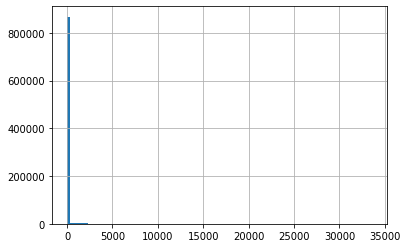

In [ ]:
data['recoveries'].hist(bins=100)

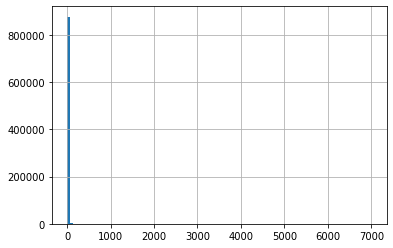

In [ ]:
data['collection_recovery_fee'].hist(bins=100)

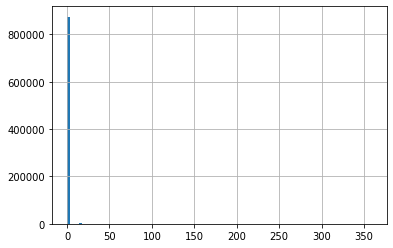

In [ ]:
data['total_rec_late_fee'].hist(bins=100)


In [ ]:
#(data['recoveries']==0).count()
(data['total_rec_late_fee']==0).count()
#(data['collection_recovery_fee']==0).count()

887379

As we can see the 3 variables mentioned above have a very high concentration, almost all of the values are 0, thus we can delete them

In [ ]:
del data['total_rec_late_fee']
del data['recoveries']
del data['collection_recovery_fee']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      887379 non-null  int64  
 1   member_id               887379 non-null  int64  
 2   loan_amnt               887379 non-null  float64
 3   funded_amnt             887379 non-null  float64
 4   funded_amnt_inv         887379 non-null  float64
 5   term                    887379 non-null  int64  
 6   int_rate                887379 non-null  float64
 7   installment             887379 non-null  float64
 8   grade                   887379 non-null  object 
 9   sub_grade               887379 non-null  object 
 10  emp_title               835917 non-null  object 
 11  home_ownership          887379 non-null  object 
 12  annual_inc              887375 non-null  float64
 13  verification_status     887379 non-null  object 
 14  purpose             

###7. ETL process complete

In [ ]:
data.to_csv("/content/drive/MyDrive/loan_etl_full.csv", index=False)

#**Feature pre-selection** 

---



### **Correlation analysis**

Load the prepared data

In [ ]:
path = "/content/drive/MyDrive/loan_etl_full.csv"
data_etl = pd.read_csv(path, engine='python')
#data_etl=data #if proceeding in one go

In [ ]:
data_etl.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_flag,cr_history_length,since_last_cr_pull,since_issue,since_last_pnmt,emp_length_num
0,1077501,1296599,5000.0,5000.0,4975.0,36,10.65,162.87,B,B2,RENT,24000.0,Verified,credit_card,AZ,27.65,0.0,1.0,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,171.62,NaN,NaN,NaN,0,13879.0,2557.0,4049,2922.0,10.0
1,1077430,1314167,2500.0,2500.0,2500.0,60,15.27,59.83,C,C4,RENT,30000.0,Source Verified,car,GA,1.00,0.0,5.0,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,119.66,NaN,NaN,NaN,1,8676.0,3409.0,4049,3562.0,0.0
2,1077175,1313524,2400.0,2400.0,2400.0,36,15.96,84.33,C,C5,RENT,12252.0,Not Verified,small_business,IL,8.72,0.0,2.0,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,649.91,NaN,NaN,NaN,0,7731.0,2557.0,4049,3136.0,10.0
3,1076863,1277178,10000.0,10000.0,10000.0,36,13.49,339.31,C,C1,RENT,49200.0,Source Verified,other,CA,20.00,0.0,1.0,35.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,357.48,NaN,NaN,NaN,0,9831.0,2922.0,4049,2922.0,10.0
4,1075358,1311748,3000.0,3000.0,3000.0,60,12.69,67.79,B,B5,RENT,80000.0,Source Verified,other,OR,17.94,0.0,0.0,38.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,67.79,NaN,NaN,NaN,0,9862.0,2557.0,4049,2557.0,1.0


In [ ]:
data_etl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      887379 non-null  int64  
 1   member_id               887379 non-null  int64  
 2   loan_amnt               887379 non-null  float64
 3   funded_amnt             887379 non-null  float64
 4   funded_amnt_inv         887379 non-null  float64
 5   term                    887379 non-null  int64  
 6   int_rate                887379 non-null  float64
 7   installment             887379 non-null  float64
 8   grade                   887379 non-null  object 
 9   sub_grade               887379 non-null  object 
 10  home_ownership          887379 non-null  object 
 11  annual_inc              887375 non-null  float64
 12  verification_status     887379 non-null  object 
 13  purpose                 887379 non-null  object 
 14  addr_state          

In [ ]:
# Find correlation with the target and sort
correlations = data_etl.corr()['default_flag'].sort_values()

# Display correlations
print('Most Postive Correlations:\n', correlations.tail(13))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Postive Correlations:
 funded_amnt           0.000979
loan_amnt             0.001657
dti                   0.009126
installment           0.011653
term                  0.038862
revol_util            0.046778
total_rec_int         0.061359
inq_last_6mths        0.069164
since_last_cr_pull    0.152379
int_rate              0.170069
since_issue           0.173428
since_last_pnmt       0.257462
default_flag          1.000000
Name: default_flag, dtype: float64

Most Negative Correlations:
 member_id          -0.197888
id                 -0.197742
out_prncp          -0.174308
out_prncp_inv      -0.174305
last_pymnt_amnt    -0.095703
total_rec_prncp    -0.093326
total_pymnt_inv    -0.041272
total_pymnt        -0.040807
tot_cur_bal        -0.038387
total_rev_hi_lim   -0.037400
Name: default_flag, dtype: float64


In [ ]:
data_etl.corr()

In [ ]:
data_etl[['out_prncp','out_prncp_inv']].corr()

As mentioned earlier, loan_amnt, funded_amnt and funded_amnt_inv are very similar, correlation over 0,98 thus we pick only the one with the highest correlation with our target variable, which is loan_amnt and drop the rest. Same with total_pynmnt and total_pynmt_inv and out_prncp

In [ ]:
del data_etl['funded_amnt']
del data_etl['funded_amnt_inv']
del data_etl['total_pymnt']
del data_etl['out_prncp']

In [ ]:
data_etl.head()

### **Object type vars**

We already have quite some number of variables fairly correlated with our default flag. Now investigate a couple of promising object type variables. Since we already transformed majority of variables into numeric types we're left with only 6 object typ vars: grade, sub grade, home ownership, verification status, purpose and state. Since grade can be thougt of as ordinal (A is best etc) we can transform it into numerical vars

Text(0.5, 0, 'target 0')

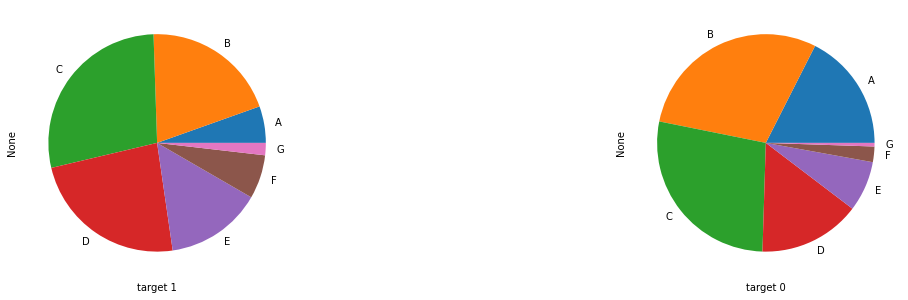

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
data_etl.loc[data_etl["default_flag"]==1, "grade"].reset_index().groupby("grade").size().plot(kind="pie", ax=ax1)
data_etl.loc[data_etl["default_flag"]==0, "grade"].reset_index().groupby("grade").size().plot(kind="pie", ax=ax2)

ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

Looks promising

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
data_etl.loc[data_etl["default_flag"]==1, "sub_grade"].reset_index().groupby("sub_grade").size().plot(kind="pie", ax=ax1)
data_etl.loc[data_etl["default_flag"]==0, "sub_grade"].reset_index().groupby("sub_grade").size().plot(kind="pie", ax=ax2)

ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

**Home Ownership**

Text(0.5, 0, 'target 0')

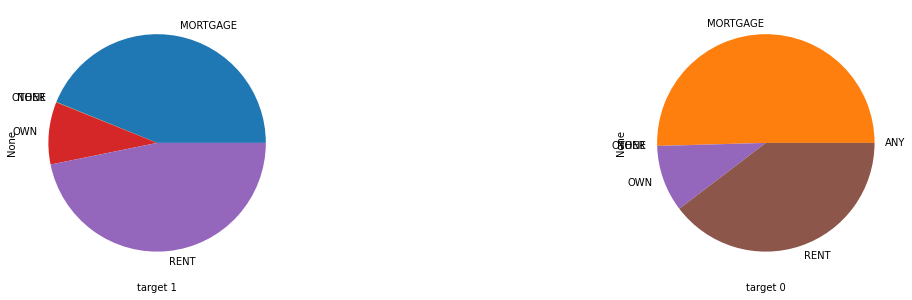

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
data_etl.loc[data_etl["default_flag"]==1, "home_ownership"].reset_index().groupby("home_ownership").size().plot(kind="pie", ax=ax1)
data_etl.loc[data_etl["default_flag"]==0, "home_ownership"].reset_index().groupby("home_ownership").size().plot(kind="pie", ax=ax2)

ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

Does  look promising- visible difference, but it will be convenient to merge the smallest counts into one category

In [ ]:
s=data_etl['home_ownership'].value_counts()
merged=s.groupby(np.where(s>=3000,s.index,'other')).sum()
#data_etl['home_own_merged']=s.groupby(np.where(s>=3000,s.index,'other')).sum()#.plot.pie()

In [ ]:
merged

MORTGAGE    443557
OWN          87470
RENT        356117
other          235
Name: home_ownership, dtype: int64

In [ ]:
data_etl['home_own_merged']=data_etl['home_ownership'].map({'MORTGAGE': 'MORTGAGE','RENT': 'RENT', 'OWN': 'OWN', 'OTHER': 'OTHER', 'NONE': 'OTHER', 'ANY': 'OTHER'})

In [ ]:
del data_etl['home_ownership']

**Verification Status**

Text(0.5, 0, 'target 0')

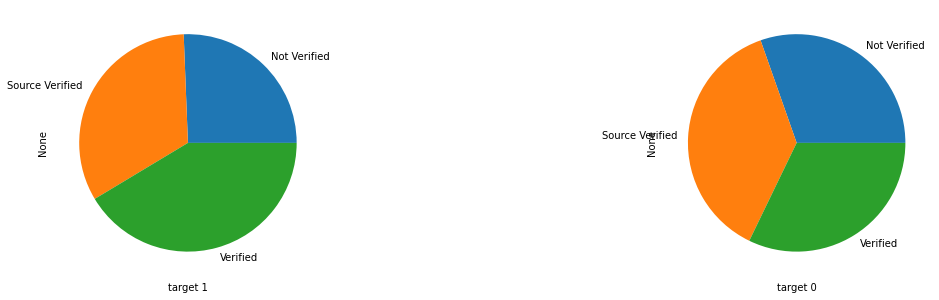

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
data_etl.loc[data_etl["default_flag"]==1, "verification_status"].reset_index().groupby("verification_status").size().plot(kind="pie", ax=ax1)
data_etl.loc[data_etl["default_flag"]==0, "verification_status"].reset_index().groupby("verification_status").size().plot(kind="pie", ax=ax2)

ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

**Purpose**

Text(0.5, 0, 'target 0')

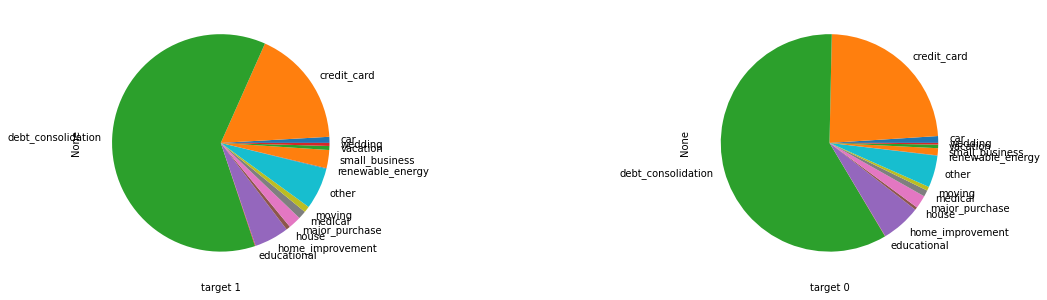

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
data_etl.loc[data_etl["default_flag"]==1, "purpose"].reset_index().groupby("purpose").size().plot(kind="pie", ax=ax1)
data_etl.loc[data_etl["default_flag"]==0, "purpose"].reset_index().groupby("purpose").size().plot(kind="pie", ax=ax2)

ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

**Address State**

Text(0.5, 0, 'target 0')

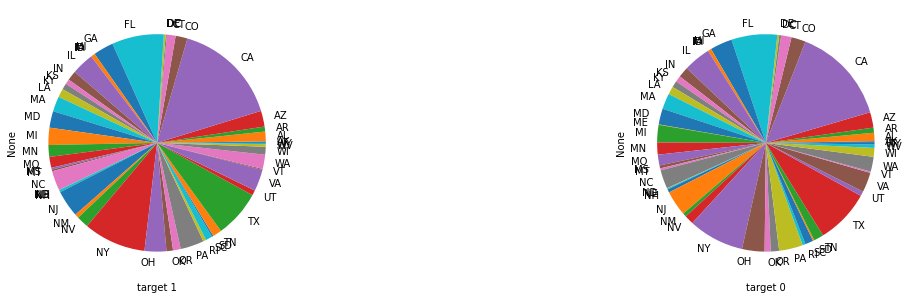

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
data_etl.loc[data_etl["default_flag"]==1, "addr_state"].reset_index().groupby("addr_state").size().plot(kind="pie", ax=ax1)
data_etl.loc[data_etl["default_flag"]==0, "addr_state"].reset_index().groupby("addr_state").size().plot(kind="pie", ax=ax2)

ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

**Initial List Status**

Text(0.5, 0, 'target 0')

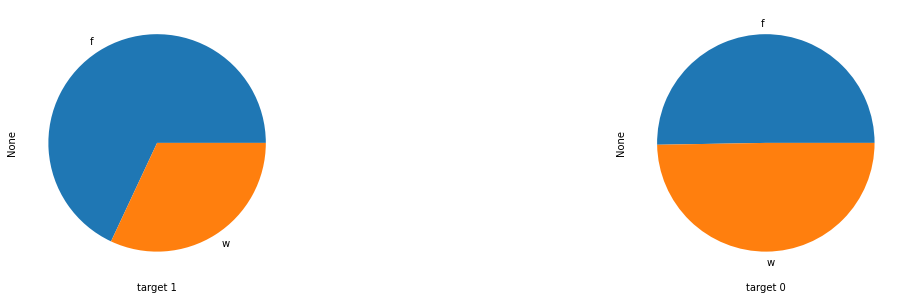

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
data_etl.loc[data_etl["default_flag"]==1, "initial_list_status"].reset_index().groupby("initial_list_status").size().plot(kind="pie", ax=ax1)
data_etl.loc[data_etl["default_flag"]==0, "initial_list_status"].reset_index().groupby("initial_list_status").size().plot(kind="pie", ax=ax2)

ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

Of the  variables plotted above, there are a couple of promising variables:
*  home_ownership
*  initial_list_status
*   Grade




# 3. Feature final selection and encoding

We select numerical variables correlated with default flag above 5%, home_ownership and intiial_list_status and grade

In [ ]:
# Find correlation with the target and sort
correlations = data_etl.corr()['default_flag'].sort_values()

# Display correlations
print('Most Postive Correlations:\n', correlations.tail(13))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Postive Correlations:
 tot_coll_amt         -0.001642
loan_amnt             0.001657
dti                   0.009126
installment           0.011653
term                  0.038862
revol_util            0.046778
total_rec_int         0.061359
inq_last_6mths        0.069164
since_last_cr_pull    0.152379
int_rate              0.170069
since_issue           0.173428
since_last_pnmt       0.257462
default_flag          1.000000
Name: default_flag, dtype: float64

Most Negative Correlations:
 member_id          -0.197888
id                 -0.197742
out_prncp_inv      -0.174305
last_pymnt_amnt    -0.095703
total_rec_prncp    -0.093326
total_pymnt_inv    -0.041272
tot_cur_bal        -0.038387
total_rev_hi_lim   -0.037400
annual_inc         -0.036104
revol_bal          -0.021974
Name: default_flag, dtype: float64


In [ ]:
data_selected=data_etl[['default_flag','since_last_pnmt','since_issue','int_rate','since_last_cr_pull','out_prncp_inv','last_pymnt_amnt','home_own_merged',
                       'initial_list_status','grade', 'verification_status']]

At the very beginning, Grade variable is ordinal so we can transform it into numbers:

In [ ]:
test_keys=data_selected['grade'].unique().tolist()
test_values=np.arange(7).tolist()
res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}
data_selected['grade_num']=data_selected['grade'].map(res)
del data_selected['grade']

<ipython-input-10-c309a0394926>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['grade_num']=data_selected['grade'].map(res)


In [ ]:
data_selected['grade_num'].value_counts()

0    254535
1    245860
2    148202
5    139542
3     70705
4     23046
6      5489
Name: grade_num, dtype: int64

Correlation heatmap

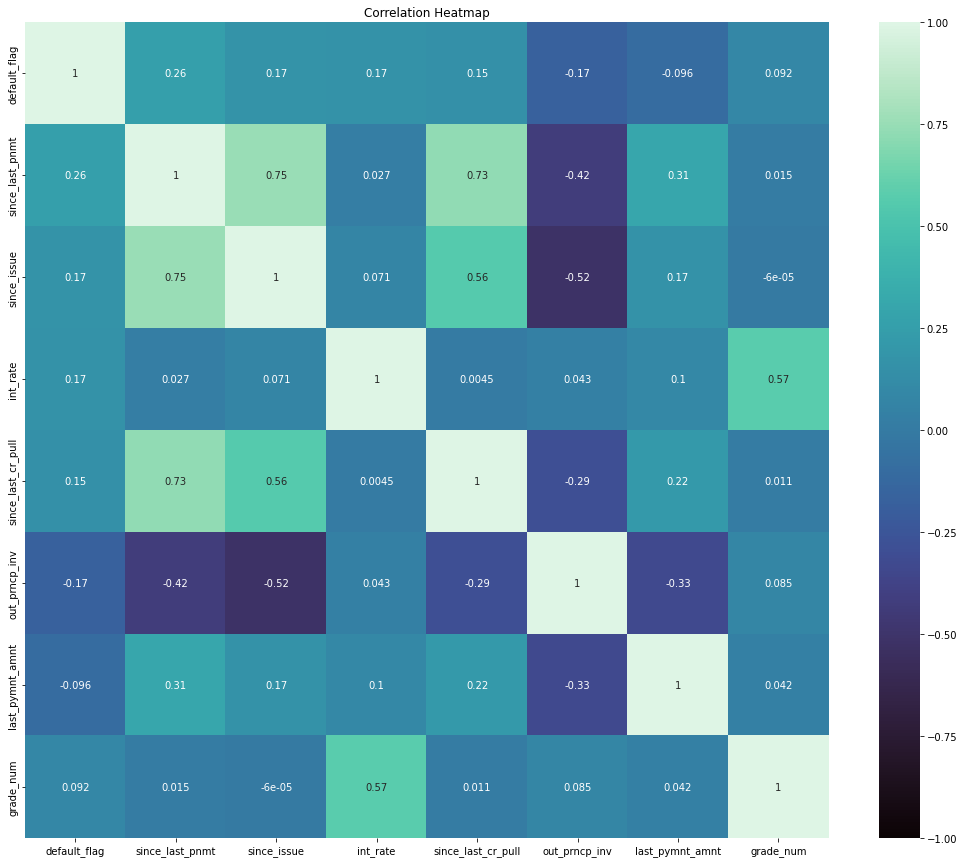

In [ ]:
corr = data_selected.corr()

plt.figure(figsize=(18,15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show()





We're left with 3 object variables that have to be one hot encoded: home ownership, verification_status and initial_list_status

In [ ]:
h_ownership_dummies = pd.get_dummies(data_selected['home_own_merged'],prefix='home_own_merged')
initial_status_dummies = pd.get_dummies(data_selected['initial_list_status'],prefix='initial_list_status')
verification_dummies=pd.get_dummies(data_selected['verification_status'],prefix='verification_status')

In [ ]:
data_selected = pd.concat([data_selected, h_ownership_dummies, initial_status_dummies, verification_dummies], axis=1)

In [ ]:
data_selected=data_selected.drop(['home_own_merged','initial_list_status','verification_status'], axis=1)

Now it's time to check for Nulls in the final dataset

In [ ]:
data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   default_flag                         887379 non-null  int64  
 1   since_last_pnmt                      869720 non-null  float64
 2   since_issue                          887379 non-null  int64  
 3   int_rate                             887379 non-null  float64
 4   since_last_cr_pull                   887326 non-null  float64
 5   out_prncp_inv                        887379 non-null  float64
 6   last_pymnt_amnt                      887379 non-null  float64
 7   total_rec_prncp                      887379 non-null  float64
 8   inq_last_6mths                       887350 non-null  float64
 9   total_rec_int                        887379 non-null  float64
 10  grade_num                            887379 non-null  int64  
 11  home_own_merg

The smallest number of non nulls is in since_last_pnmt which is still aroun 98%, so we can drop all the rows containing N/A

In [ ]:
data_selected.head()

,default_flag,since_last_pnmt,since_issue,int_rate,since_last_cr_pull,out_prncp_inv,last_pymnt_amnt,total_rec_prncp,inq_last_6mths,total_rec_int,grade_num,home_own_merged_MORTGAGE,home_own_merged_OTHER,home_own_merged_OWN,home_own_merged_RENT,initial_list_status_f,initial_list_status_w,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,0,2922.0,4049,10.65,2557.0,0.0,171.62,5000.00,1.0,861.07,0,0,0,0,1,1,0,0,0,1
1,1,3562.0,4049,15.27,3409.0,0.0,119.66,456.46,5.0,435.17,1,0,0,0,1,1,0,0,1,0
2,0,3136.0,4049,15.96,2557.0,0.0,649.91,2400.00,2.0,603.65,1,0,0,0,1,1,0,1,0,0
3,0,2922.0,4049,13.49,2922.0,0.0,357.48,10000.00,1.0,2209.33,1,0,0,0,1,1,0,0,1,0
4,0,2557.0,4049,12.69,2557.0,766.9,67.79,2233.10,0.0,1009.07,0,0,0,0,1,1,0,0,1,0


In [ ]:
data_selected.dropna(axis=0, how='any', inplace=True)

#4. Split, divide and balance the set

In [ ]:
y = data_selected.iloc[:, 0].values
x = data_selected.iloc[:, 1:].values

Smote

In [ ]:
smote=SMOTE()

In [ ]:
x_smote, y_smote = smote.fit_resample(x, y)

#5. Scaling Data and splitting




In [ ]:
sc = StandardScaler()
x_smote = sc.fit_transform(x_smote)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = .25, random_state = 10)

Also we're gonna want to test the model on a natural, imbalanced dataset

In [ ]:
x_1=sc.fit_transform(x)

In [ ]:
x_train_un, x_test_un, y_train_un, y_test_un = train_test_split(x_1, y, test_size = .25, random_state = 10)

# 6. Modelling 

###1. Logistic Regression

Most widely used in credit risk analysis, simple logistic regression model

Train

In [ ]:
classifier =  LogisticRegression(max_iter=3000)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

Metrics

In [ ]:
log_accuracy=accuracy_score(y_test, y_pred)
log_recall=recall_score(y_test,y_pred)
log_precision=precision_score(y_test,y_pred)
log_rocauc=roc_auc_score(y_test,y_pred)

In [ ]:
print('{:.4f}'.format(log_accuracy), '- Log Accuracy')
print('{:.4f}'.format(log_recall), '- Log Recall')
print('{:.4f}'.format(log_precision), '- Log Precision')
print('{:.4f}'.format(log_rocauc), '- Log ROC AUC')

0.8502 - Log Accuracy
0.8223 - Log Recall
0.8708 - Log Precision
0.8502 - Log ROC AUC


Test on unbalanced

In [ ]:
y_pred_un=classifier.predict(x_test_un)

In [ ]:
log_accuracy=accuracy_score(y_test_un, y_pred_un)
log_recall=recall_score(y_test_un,y_pred_un)
log_precision=precision_score(y_test_un,y_pred_un)
log_rocauc=roc_auc_score(y_test_un,y_pred_un)
print('{:.4f}'.format(log_accuracy), '- Log Accuracy')
print('{:.4f}'.format(log_recall), '- Log Recall')
print('{:.4f}'.format(log_precision), '- Log Precision')
print('{:.4f}'.format(log_rocauc), '- Log ROC AUC')

0.5284 - Log Accuracy
0.9684 - Log Recall
0.1236 - Log Precision
0.7323 - Log ROC AUC


Predictions

In [ ]:
predictions = classifier.predict_proba(x_test)
predictions

array([[0.34067347, 0.65932653],
       [0.50856374, 0.49143626],
       [0.13309466, 0.86690534],
       ...,
       [0.83499367, 0.16500633],
       [0.5839613 , 0.4160387 ],
       [0.28567177, 0.71432823]])

In [ ]:
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])
df_prediction_target = pd.DataFrame(classifier.predict(x_test), columns = ['predicted_TARGET'])
df_test_dataset = pd.DataFrame(y_test,columns= ['Actual Outcome'])

df=pd.concat([df_test_dataset, df_prediction_prob, df_prediction_target], axis=1)
df.sort_values(by=['prob_0'],  ascending=[False],inplace=True)

In [ ]:
df

,Actual Outcome,prob_0,prob_1,predicted_TARGET
144755,0,1.000000e+00,4.609244e-17,0
131497,0,1.000000e+00,1.527995e-17,0
392060,0,1.000000e+00,8.328602e-20,0
295505,0,1.000000e+00,6.483921e-18,0
185207,0,1.000000e+00,1.184330e-17,0
...,...,...,...,...
218089,0,2.319140e-10,1.000000e+00,1
219445,0,1.733182e-10,1.000000e+00,1
319637,0,1.671423e-10,1.000000e+00,1
177953,0,1.541389e-10,1.000000e+00,1


Confusion Matrix

In [ ]:
confusion_matrix_logit = confusion_matrix(y_test, y_pred)
print(confusion_matrix_logit)
#pd.crosstab(y_test,y_pred)

[[177862  24698]
 [ 35979 166440]]


###2. **KNN**

In [ ]:
n = 2
knn = KNeighborsClassifier(n_neighbors = n)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

KeyboardInterrupt: ignored

In [ ]:
log_accuracy=accuracy_score(y_test, y_pred)
log_recall=recall_score(y_test,y_pred)
log_precision=precision_score(y_test,y_pred)
log_rocauc=roc_auc_score(y_test,y_pred)

print('{:.4f}'.format(log_accuracy), '- Log Accuracy')
print('{:.4f}'.format(log_recall), '- Log Recall')
print('{:.4f}'.format(log_precision), '- Log Precision')
print('{:.4f}'.format(log_rocauc), '- Log ROC AUC')

In [ ]:
#confusion_matrix = confusion_matrix(y_test, y_pred)
#print(confusion_matrix)
pd.crosstab(y_test,y_pred)

KNN is too time-complex for such large dataset

###3. SVM

In [ ]:
svm = LinearSVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
log_accuracy=accuracy_score(y_test, y_pred)
log_recall=recall_score(y_test,y_pred)
log_precision=precision_score(y_test,y_pred)
log_rocauc=roc_auc_score(y_test,y_pred)

print('{:.4f}'.format(log_accuracy), '- Log Accuracy')
print('{:.4f}'.format(log_recall), '- Log Recall')
print('{:.4f}'.format(log_precision), '- Log Precision')
print('{:.4f}'.format(log_rocauc), '- Log ROC AUC')

0.8345 - Log Accuracy
0.8061 - Log Recall
0.8545 - Log Precision
0.8345 - Log ROC AUC


In [ ]:
pd.crosstab(y_test,y_pred)

col_0,0,1
row_0,,
0,174786,27774
1,39252,163167


Metrics lookg good but the message 'liblinear failed to converge' suggests that the algorithm does not work so well

###4. Decision trees

In [ ]:
dtree = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=5, min_samples_leaf=5)
dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)

In [ ]:
log_accuracy=accuracy_score(y_test, y_pred)
log_recall=recall_score(y_test,y_pred)
log_precision=precision_score(y_test,y_pred)
log_rocauc=roc_auc_score(y_test,y_pred)

print('{:.4f}'.format(log_accuracy), '- Log Accuracy')
print('{:.4f}'.format(log_recall), '- Log Recall')
print('{:.4f}'.format(log_precision), '- Log Precision')
print('{:.4f}'.format(log_rocauc), '- Log ROC AUC')

0.9580 - Log Accuracy
0.9664 - Log Recall
0.9504 - Log Precision
0.9580 - Log ROC AUC


In [ ]:
pd.crosstab(y_test,y_pred)

col_0,0,1
row_0,,
0,192346,10214
1,6794,195625


Seems that decision tress have the highest metrics of all - 96% ROC AUC

###5. Visualization

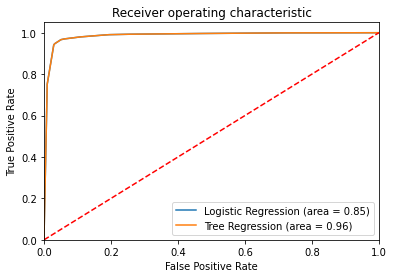

In [ ]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(x_test))
tree_roc_auc = roc_auc_score(y_test, dtree.predict(x_test))
#knn_roc_auc = roc_auc_score(y_test, knn.predict(x_test))

fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(x_test)[:,1])
#fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, dtree.predict_proba(x_test)[:,1])
#fpr, tpr, thresholds = roc_curve(y_test, svm.decision_function(x_test))

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr, tpr, label='Tree Regression (area = %0.2f)' % tree_roc_auc)
#plt.plot(fpr, tpr, label='Support Vector Machines (area = %0.2f)' % svm_roc_auc)
#plt.plot(fpr, tpr, label='K-nearest neighbours (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()